In [435]:
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

#sns.set(style="darkgrid")

In [375]:
def Noise_Gen(tm,amp):
    noise=[]
    time=[]
    for i in range(tm):
        noise.append(np.random.normal(0,amp))
        time.append(i)
    return np.array(time), np.array(noise)

def Sig_Gen(tm,t0,w,amp):
    s=[]
    t=[]
    for i in range(tm):
        s.append(((np.sqrt(2*np.exp(1)))/w)*amp*(i-t0)*np.exp(-(i-t0)**2/(w**2)))
        t.append(i)
    return np.array(t), np.array(s)

def TS_Correlations(time,data,kernel):
    kernel=0.96787*np.sqrt(2)*kernel/np.sum(np.abs(kernel))
    output=[]
    tout=[]
    for i in range(len(data)):
        if i < len(data)-len(kernel):
            output.append(np.correlate(data[i:i+len(kernel)],kernel)[0])
            tout.append(time[int(i+len(kernel)/2)])
    return(tout,output)


def SNR_Filter(xdata,ydata,filter_kernel):
    fitval=[]
    fiterr=[]
    noise=[]
    rs=[]
    signal_quad=[]
    tval=[]

    i=0
    xdat=[i for i in range(len(filter_kernel))]

    for i in range(len(ydata)-len(filter_kernel)):
        tval.append(xdata[i])
        ydat=ydata[i:i+len(filter_kernel)]
        popt,pcov = curve_fit(filter_func,xdat,ydat)

        fitval.append(popt[0])
        fiterr.append(np.sqrt(pcov[0][0]))

        signal_fitted=filter_func(1,popt)

        residuals = ydat-filter_func(1,popt)

        ss_sig=np.sqrt(np.multiply(np.sum(signal_fitted**2),1))*np.sqrt(len(filter_kernel))
        ss_res = np.sqrt(np.sum(residuals**2))
        ss_tot = np.sum((ydat-np.mean(ydat))**2)

        noise.append(ss_res)
        signal_quad.append(ss_sig)

        r_squared = 1-(ss_res / ss_tot)
        rs.append(r_squared)
    return(tval,fitval,fiterr,signal_quad,noise)



def filter_func(t,a):
    return np.multiply(a,kernel)

def gaussian(x,bb,cc,dd):
    hold=bb*np.exp(-1*(x-cc)**2/(2*dd**2))
    return hold


def TS_Correlations_Fast(time,data,kernel_pass):
    output=signal.correlate(data,kernel_pass,mode='valid',method='fft')
    output=np.divide(output,len(kernel_pass)*np.mean(kernel_pass**2))
    return(time[int(len(kernel_pass)/2)-1:-int(len(kernel_pass)/2)],output)


def SNR_Return_Fast(xdata,ydata,ydatafilt,filter_kernel):
    noise=[]
    signal_quad=[]
    tval=[]
    
    i=0
    xdat=[i for i in range(len(filter_kernel))]

    for i in range(int(len(filter_kernel)/2),len(ydata)-int(len(filter_kernel)/2-1)):
        tval.append(xdata[i])
        ydat=ydata[i-int(len(filter_kernel)/2):i+int(len(filter_kernel)/2)]
        popt=ydatafilt[i-int(len(filter_kernel)/2)]
        signal_fitted=filter_func(1,popt)
        residuals = ydat-filter_func(1,popt)

        ss_sig=np.sqrt(np.multiply(np.sum(signal_fitted**2),1))*np.sqrt(len(filter_kernel))
        ss_res = np.sqrt(np.sum(residuals**2))
        ss_tot = np.sum((ydat-np.mean(ydat))**2)

        noise.append(ss_res)
        signal_quad.append(ss_sig)

    return(np.array(tval),signal_quad,noise)

def SNR_Peak_Search(times,SNRval, width, threshold):
    peaks, _ = find_peaks(SNR_vec, height=threshold,distance=width*2)
    return(tval[peaks], SNR_vec[peaks])

In [376]:
# This notebook impliments an algorithm to get fitted signal amplitude, and the uncertainty in fitted signal amplitude
# in a fast algorithm. These algorithms can be used to search for the signals with known shape (ther kernel) and ALSO estimate 
# the error in the signal size. This allows us to identify signals with statistical prevalnce (say 5 sigma) and kick out the 
# time stamp where they occur

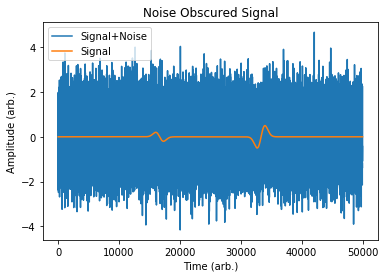

In [445]:
#Simulate two small signals, in a timeseries with amplitude 1 Gaussian Noise
tlen=50000
swidth=900
t, noise =Noise_Gen(tlen,1)
t, sig1 = Sig_Gen(tlen,int(tlen/3),swidth,-.2)
t, sig2 =Sig_Gen(tlen,int(tlen*(2/3)),swidth,.5)
sig=sig1+sig2
plt.plot(t,sig+noise,label='Signal+Noise')
plt.plot(t,sig,label='Signal')
#plt.xlim([int(tlen/2)-10*swidth,int(tlen/2)+10*(swidth)])
plt.xlabel("Time (arb.)")
plt.ylabel("Amplitude (arb.)")
plt.title("Noise Obscured Signal")
plt.legend()
plt.show()

C:\Users\Rees\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
No handles with labels found to put in legend.


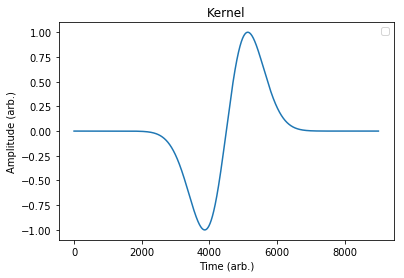

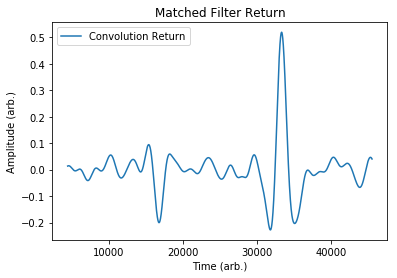

In [452]:
# Look for correlatation with the known signal shape (the kernel)

# Note that there are "sidebands" when the kernerl is offset by about its width. 
# This is expected, because of the shape of the bimodal kernel
data=sig+noise
tmask, kernel=Sig_Gen(int(swidth*10),int(swidth*5),swidth,1)
tconv,sigconv=TS_Correlations_Fast(t,data,kernel)

plt.plot(tmask, kernel)
plt.legend()
plt.xlabel("Time (arb.)")
plt.ylabel("Amplitude (arb.)")
plt.title("Kernel")
plt.show()

plt.plot(tconv,sigconv,label='Convolution Return')
plt.legend()
plt.xlabel("Time (arb.)")
plt.ylabel("Amplitude (arb.)")
plt.title("Matched Filter Return")
plt.show()

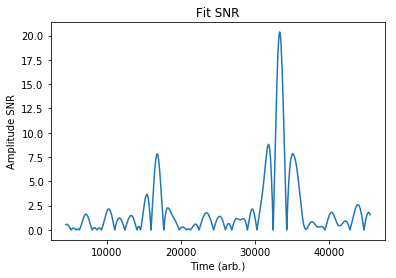

In [455]:
# Take the output from the filter, and the original data, to calculate how well the filter Matches the data.
# Here SNR_vec is the amplutide of the signal, over the amplitude of the noise. This is based on linear regression,
# and is equivalent to fitting each subset of the data to the kernerl, and taking the error in the fit. We don't
# impliment it like that however, because this is much faster

# Note, that despite the fact the inital signals are quite small, matched filters still pick them out.
tval,signal_quad,noiseval = SNR_Return_Fast(t,data,sigconv,kernel)
SNR_vec=np.abs(np.divide(signal_quad,noiseval))
plt.plot(tval,SNR_vec)
plt.xlabel("Time (arb.)")
plt.ylabel("Amplitude SNR")
plt.title("Fit SNR")
plt.show()

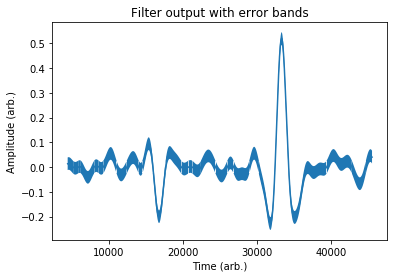

In [458]:
# We can also use this information on the fit quality, to fit the estimated signal size with 1 sigma error bands.

# Note that the size of the signal after passing through the filter is normalized
sigconv_err=np.divide(sigconv,np.divide(signal_quad,noiseval))
plt.plot(tconv,sigconv,label='Convolution Return')
plt.fill_between(tconv,np.add(sigconv,sigconv_err),np.subtract(sigconv,sigconv_err))
plt.xlabel("Time (arb.)")
plt.ylabel("Amplitude (arb.)")
plt.title("Filter output with error bands")
plt.show()


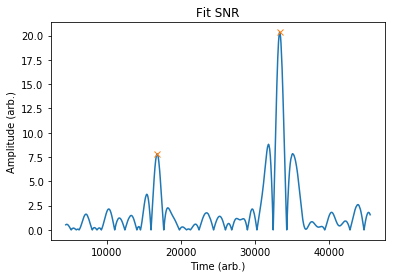

In [459]:
# Ican now take the SNR estimator, and return any times where there is a statistically relevant signal (say, and SNR above 5)
# We can then run this series of operations on the data, to see if each sensor sees an event at a similiar time to look 
# for correlations
peaktime,peakval=SNR_Peak_Search(tval,SNR_vec, 2*swidth, 5)

plt.plot(tval,SNR_vec)
plt.plot(peaktime,peakval, "x")
plt.xlabel("Time (arb.)")
plt.ylabel("Amplitude (arb.)")
plt.title("Fit SNR")
plt.show()